# Algorithmic Trading COMP0051 2023/24 Coursework 2

#### 1. Time Series Prep [30 Points]

### (a)

In [17]:
import pandas as pd

# Load the data
sptl_df = pd.read_csv('SPTL.csv')
effr_df = pd.read_excel('EFFR_rates.xlsx')

# Convert EFFR annual rate to a daily rate assuming 252 trading days in a year
effr_df['Daily Rate'] = effr_df['Rate (%)'] / 100 / 252

# Process dates for merging
effr_df['Effective Date'] = pd.to_datetime(effr_df['Effective Date'])
effr_df.set_index('Effective Date', inplace=True)
sptl_df['Date'] = pd.to_datetime(sptl_df['Date'])
sptl_df.set_index('Date', inplace=True)

# Merge the datasets on the date index
merged_df = sptl_df.join(effr_df['Daily Rate'], how='left')
merged_df['Daily Rate'].ffill(inplace=True)

# Calculate the daily price change for SPTL
merged_df['Price Change'] = merged_df['Adj Close'].diff()

# Calculate the daily excess return per unit of SPTL
merged_df['Excess Return'] = merged_df['Price Change'] / merged_df['Adj Close'] - merged_df['Daily Rate']

merged_df.head(5)


c:\Users\lyakh\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Open,High,Low,Close,Adj Close,Volume,Daily Rate,Price Change,Excess Return
Date,,,,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299057,25400,0.000003,NaN,NaN
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283548,22000,0.000003,-0.015509,-0.000669
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380453,3200,0.000003,0.096905,0.004142
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457968,3800,0.000003,0.077515,0.003302
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372698,14800,0.000003,-0.085270,-0.003651


### (b)

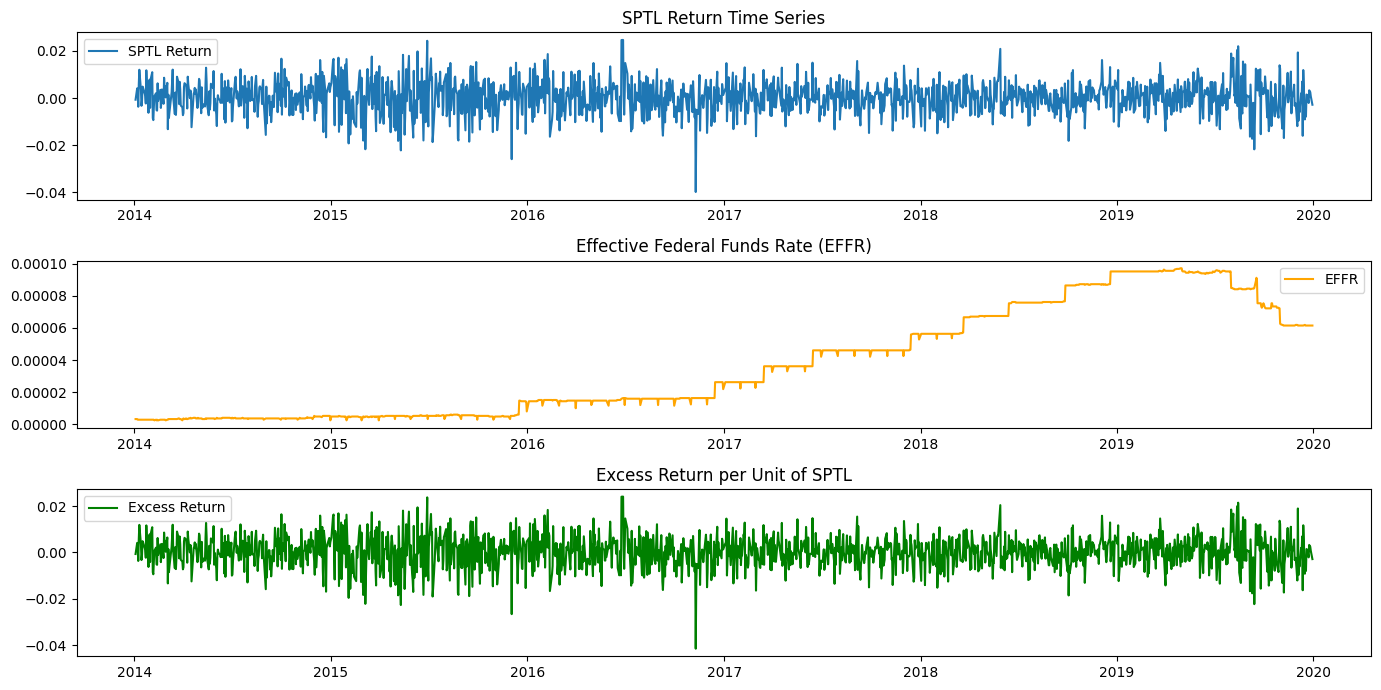

In [18]:
import matplotlib.pyplot as plt

# Calculate the daily return for SPTL
merged_df['SPTL Return'] = merged_df['Adj Close'].pct_change()

# Remove the NaN values for plotting
plot_df = merged_df.dropna(subset=['SPTL Return', 'Daily Rate', 'Excess Return'])

# Plotting
plt.figure(figsize=(14, 7))

# SPTL return time series
plt.subplot(3, 1, 1)
plt.plot(plot_df.index, plot_df['SPTL Return'], label='SPTL Return')
plt.title('SPTL Return Time Series')
plt.legend()

# EFFR time series
plt.subplot(3, 1, 2)
plt.plot(plot_df.index, plot_df['Daily Rate'], label='EFFR', color='orange')
plt.title('Effective Federal Funds Rate (EFFR)')
plt.legend()

# Excess return per unit of SPTL
plt.subplot(3, 1, 3)
plt.plot(plot_df.index, plot_df['Excess Return'], label='Excess Return', color='green')
plt.title('Excess Return per Unit of SPTL')
plt.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


#### 2. Trading Strategies [45 Points]

### (a)

In [19]:
import pandas as pd
import numpy as np

# Define constants and leverage utilization
initial_capital = 200000
leverage = 10
time_window = 10

# Assuming merged_df has been previously defined and contains the necessary data
train_days = int(len(merged_df) * 0.7)

# Split the dataset into training and test sets
train_df = merged_df.iloc[:train_days].copy()
test_df = merged_df.iloc[train_days:].copy()


short_window = 5
long_window = 20

# Calculate moving averages
for df in [train_df, test_df]:
    df['Short_MAvg'] = df['Adj Close'].rolling(window=short_window).mean()
    df['Long_MAvg'] = df['Adj Close'].rolling(window=long_window).mean()


#short if lower and long if higher
def trend_following_strategy(row):
    if np.isnan(row['Moving_Average']) or np.isnan(row['Adj Close']):
        return 0
    return initial_capital * (abs(row['Adj Close'] - row['Moving_Average']) / row['Moving_Average']) * leverage

# Define the momentum strategy function
def momentum_strategy(row):
    if np.isnan(row['Short_MAvg']) or np.isnan(row['Long_MAvg']):
        return 0
    return initial_capital * (abs(row['Short_MAvg']-row['Long_MAvg']) / row['Long_MAvg'] ) * leverage if row['Short_MAvg'] > row['Long_MAvg'] else -initial_capital * (abs(row['Short_MAvg']-row['Long_MAvg']) / row['Long_MAvg'] ) * leverage

def compute_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.abs().rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def rsi_strategy(row, capital, lev, overbought=70, oversold=30):
    if row['RSI'] > overbought:
        return -capital * 1/20 * lev
    elif row['RSI'] < oversold:
        return capital * 1/12 * lev
    return 0

# Calculate the moving average and RSI for the datasets
for df in [train_df, test_df]:
    df['Moving_Average'] = df['Adj Close'].rolling(window=time_window).mean().shift(1)
    df['RSI'] = compute_rsi(df['Adj Close'])

# Apply the strategies and calculate PnL
for df in [train_df, test_df]:
    df['Trend_Following_Strategy'] = df.apply(lambda row: trend_following_strategy(row), axis=1)
    df['Momentum_Strategy'] = df.apply(momentum_strategy, axis=1)
    df['RSI_Strategy'] = df.apply(lambda row: rsi_strategy(row, initial_capital, leverage), axis=1)
    
    df['Trend_Following_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['Trend_Following_Strategy']
    df['Momentum_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['Momentum_Strategy']
    df['RSI_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['RSI_Strategy']

# Output the tail of the training and test set to verify
print(train_df[['Adj Close', 'Moving_Average', 'Trend_Following_Strategy', 'Trend_Following_PnL',
                'Momentum_Strategy', 'Momentum_PnL', 'RSI', 'RSI_Strategy', 'RSI_PnL']].tail())

print(test_df[['Adj Close', 'Moving_Average', 'Trend_Following_Strategy', 'Trend_Following_PnL',
               'Momentum_Strategy', 'Momentum_PnL', 'RSI', 'RSI_Strategy', 'RSI_PnL']].tail())




            Adj Close  Moving_Average  Trend_Following_Strategy  \
Date                                                              
2018-03-07  29.410709       29.384198               1804.432431   
2018-03-08  29.575012       29.422143              10391.411595   
2018-03-09  29.393423       29.465299               4878.674436   
2018-03-12  29.575012       29.469585               7154.997360   
2018-03-13  29.713385       29.487713              15306.144423   

            Trend_Following_PnL  Momentum_Strategy  Momentum_PnL        RSI  \
Date                                                                          
2018-03-07           -31.329186        5394.120217    -93.654599  53.943364   
2018-03-08          1706.754552        3129.440978    514.000200  55.800482   
2018-03-09          -886.188522        2659.744747   -483.130263  47.592942   
2018-03-12          1298.865637        4159.402403    755.067344  54.389795   
2018-03-13          2117.094633        7126.024289    98

### (b)

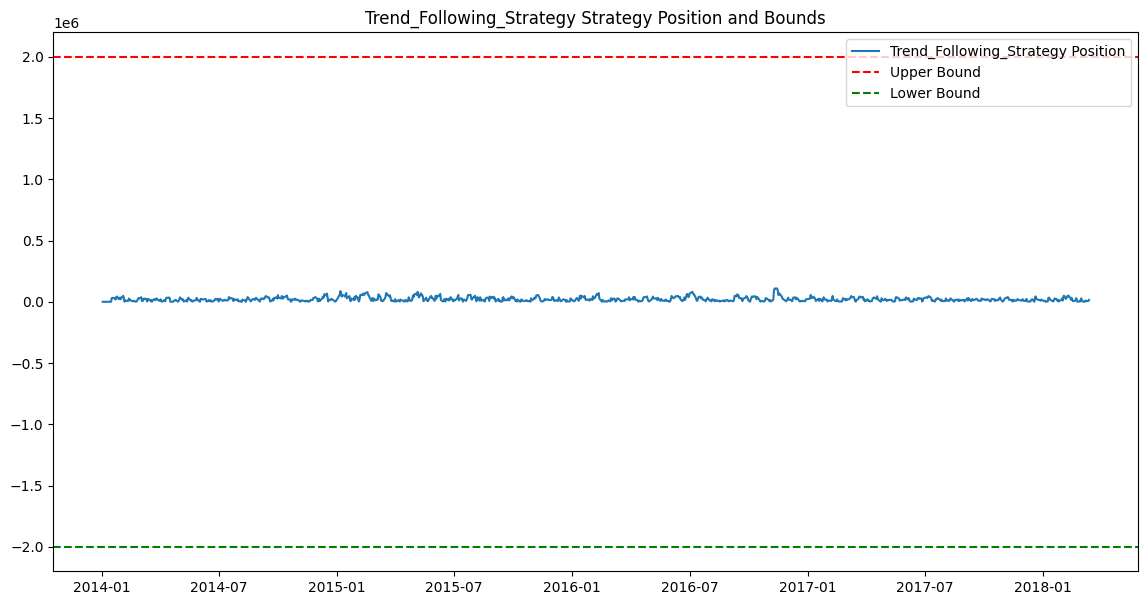

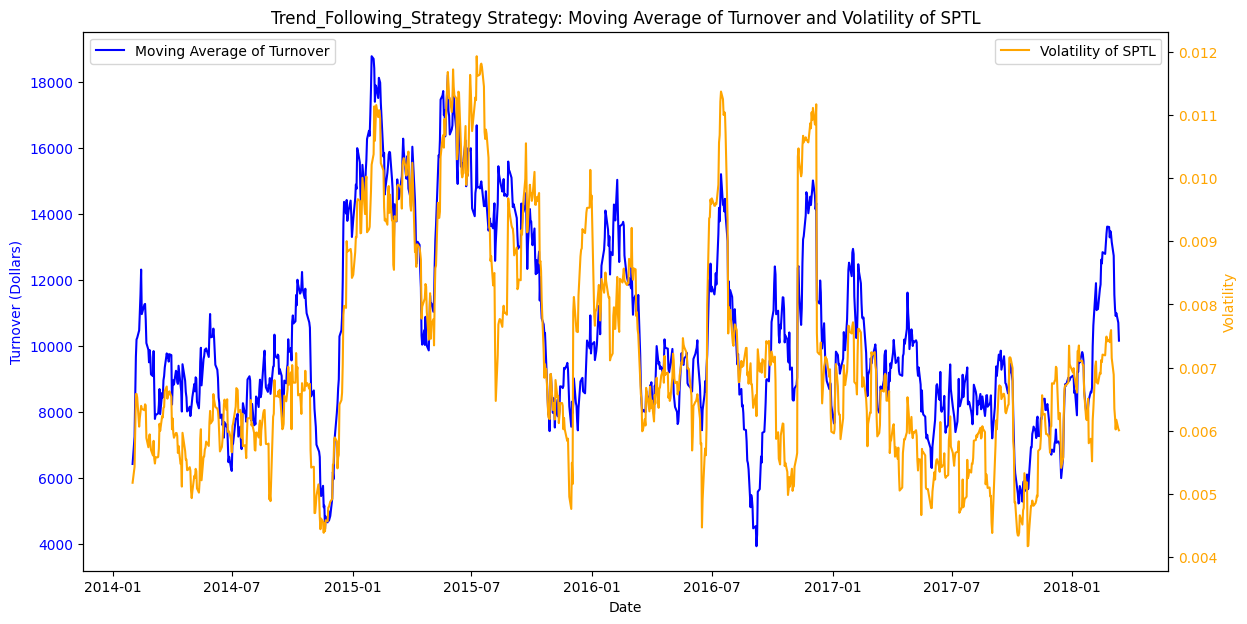

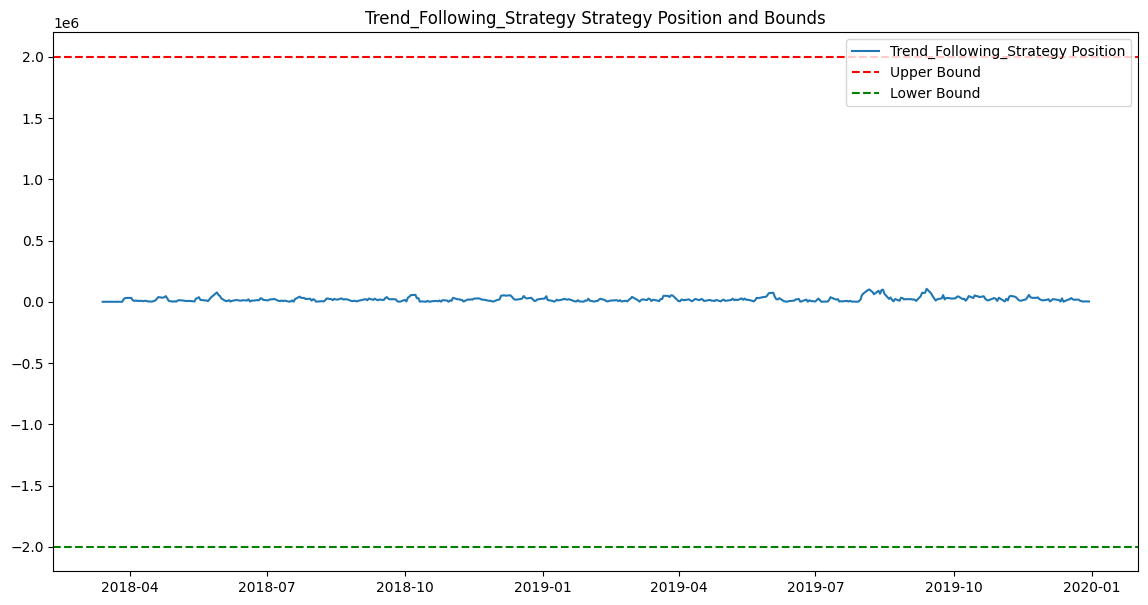

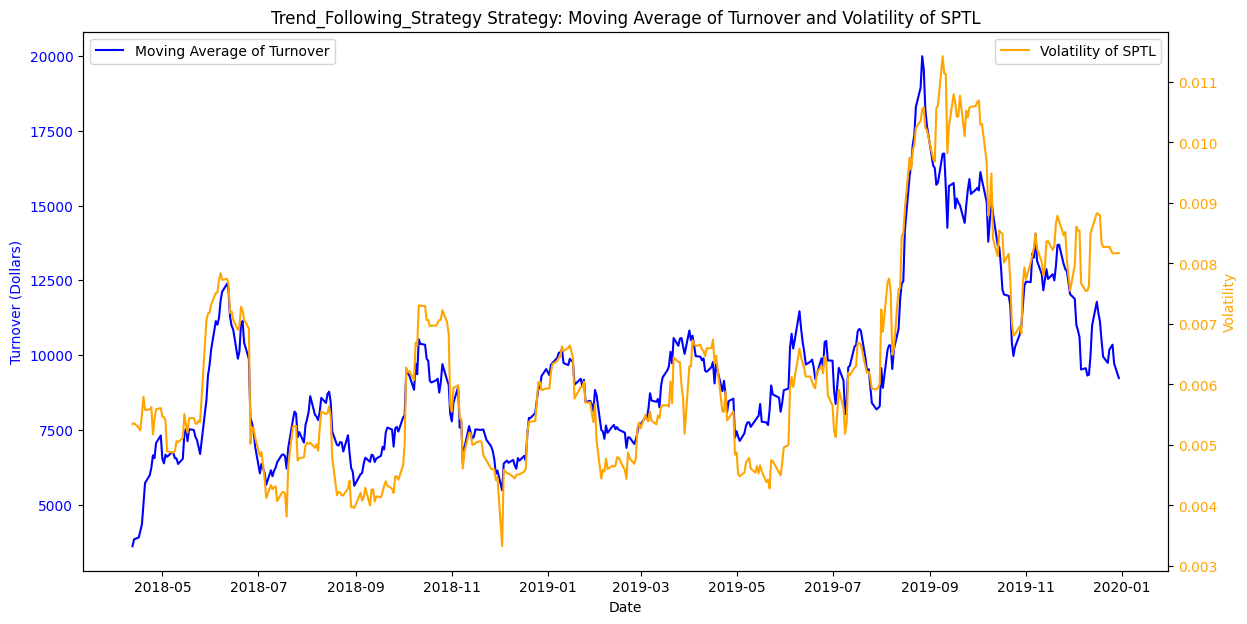

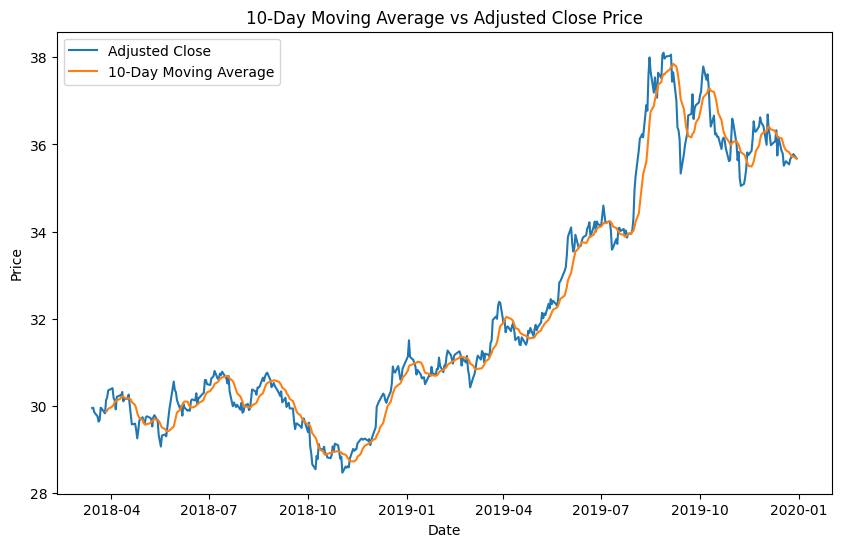

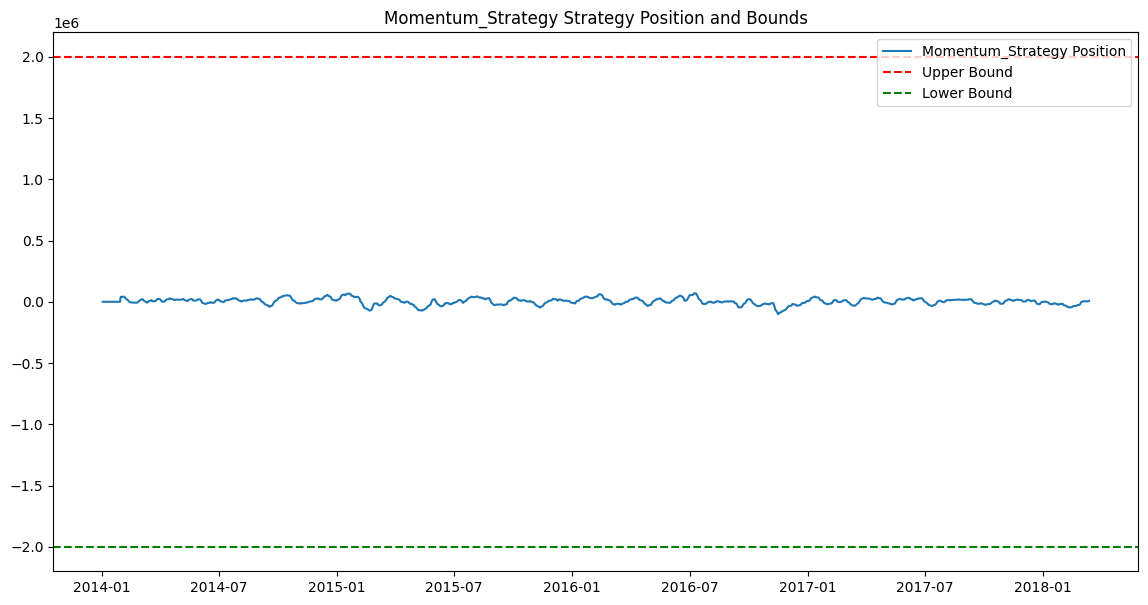

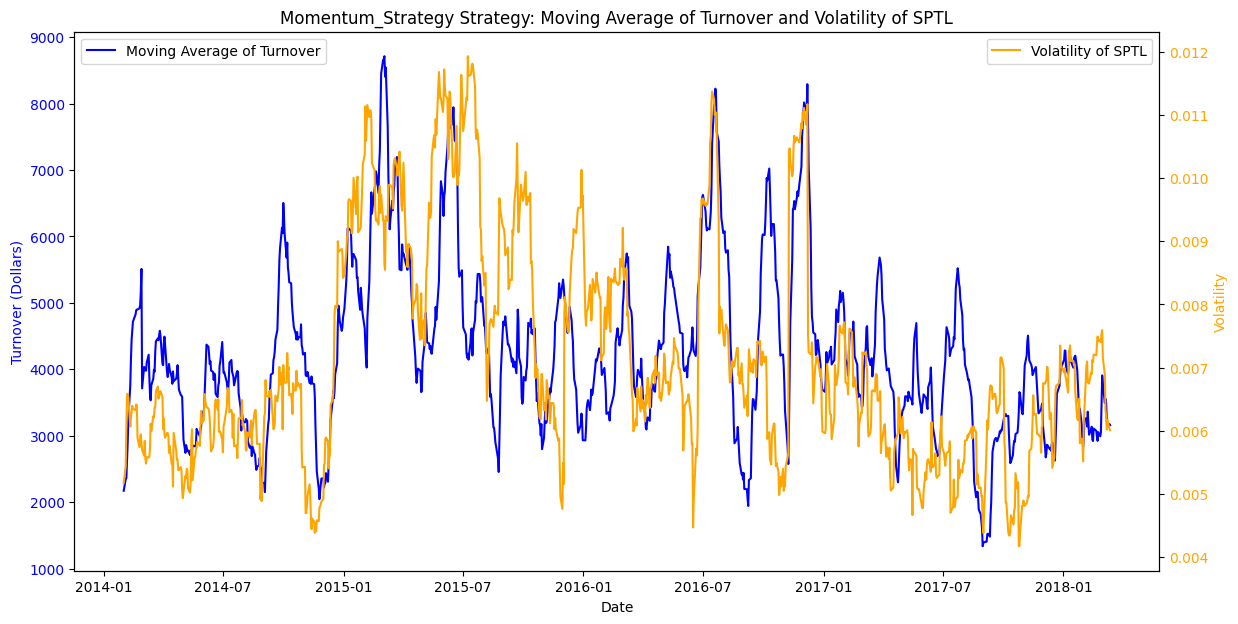

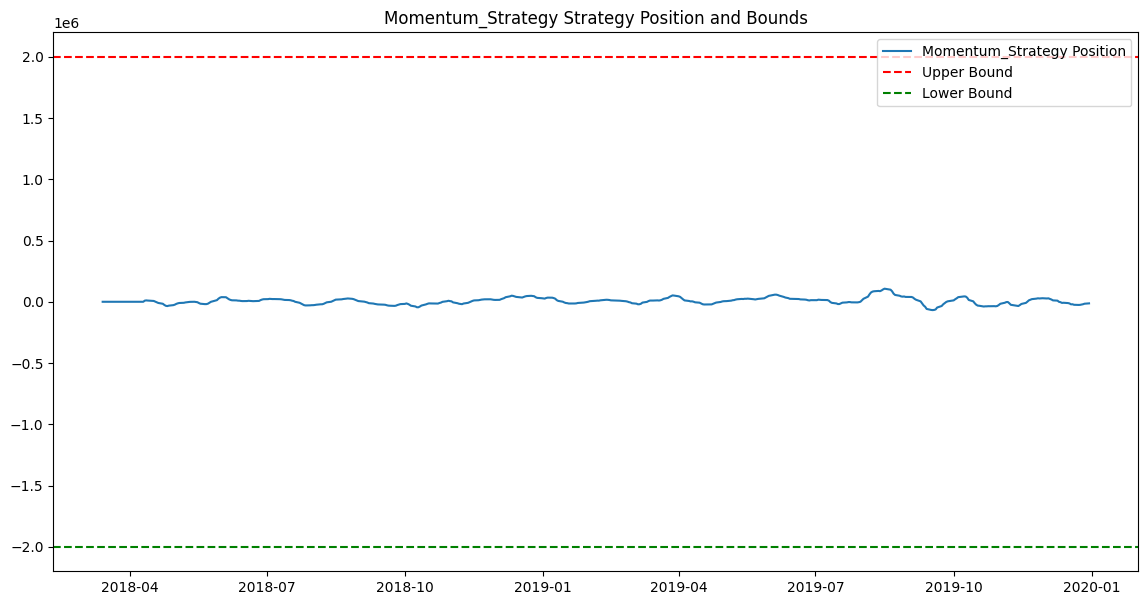

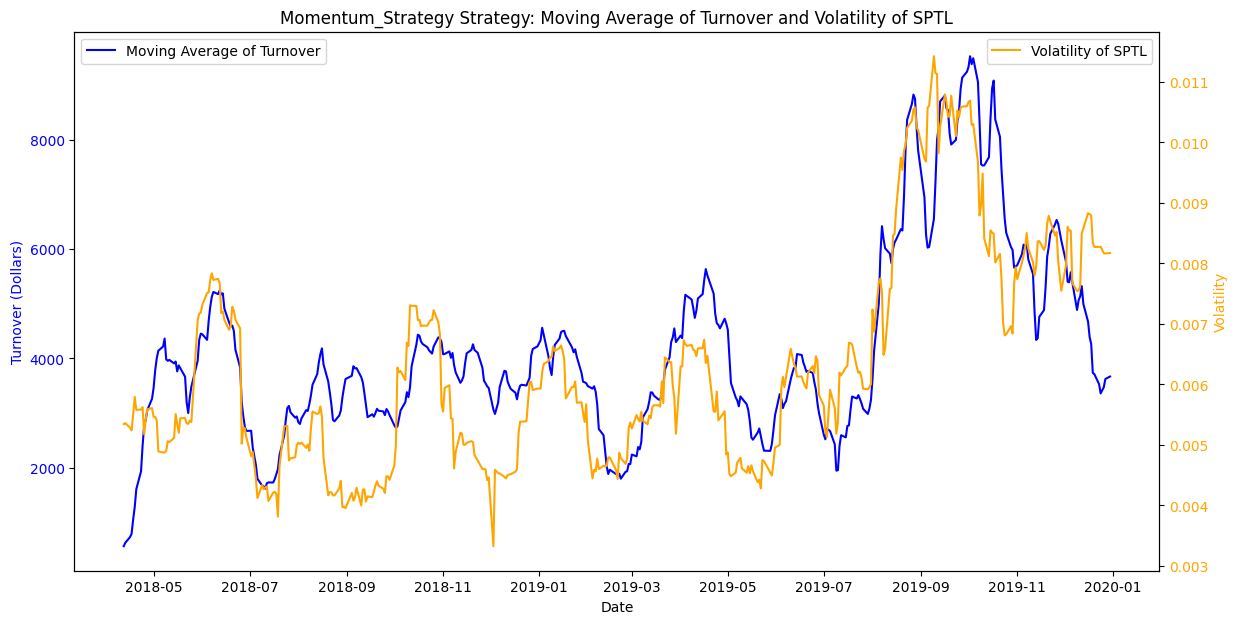

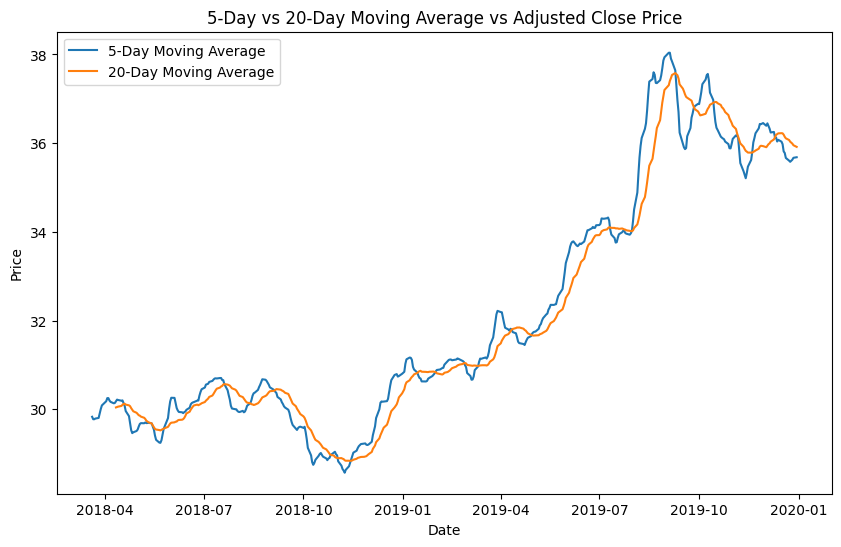

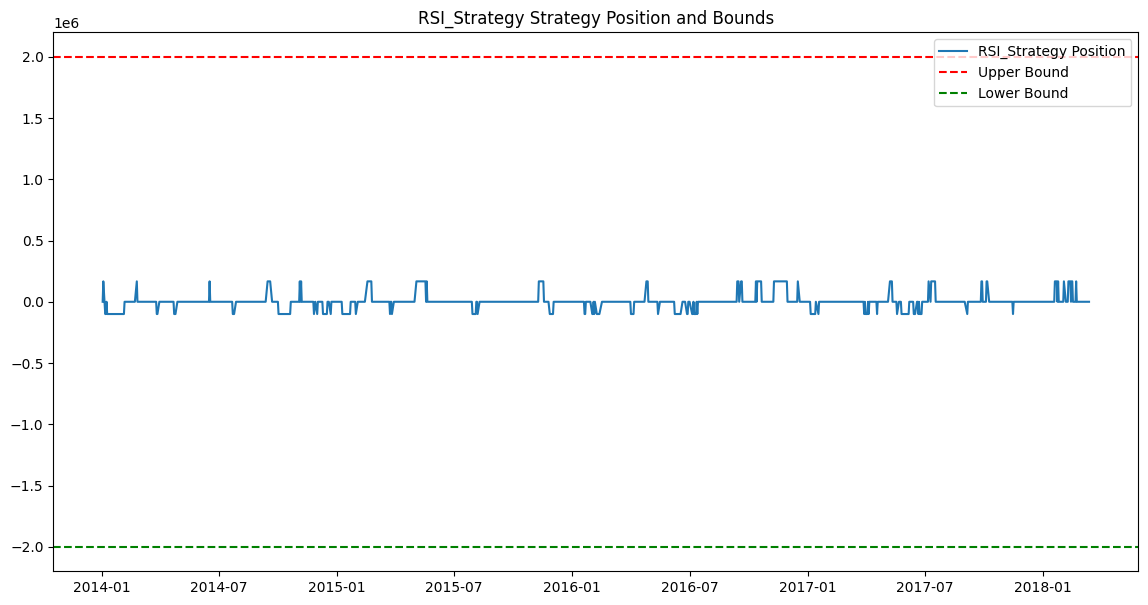

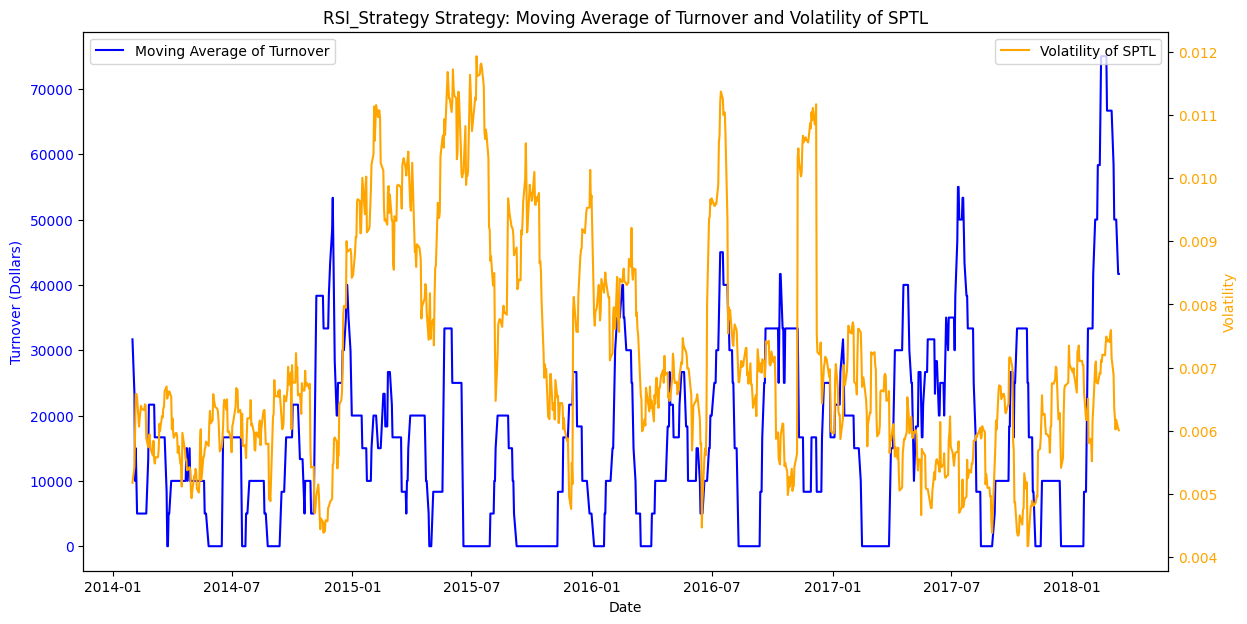

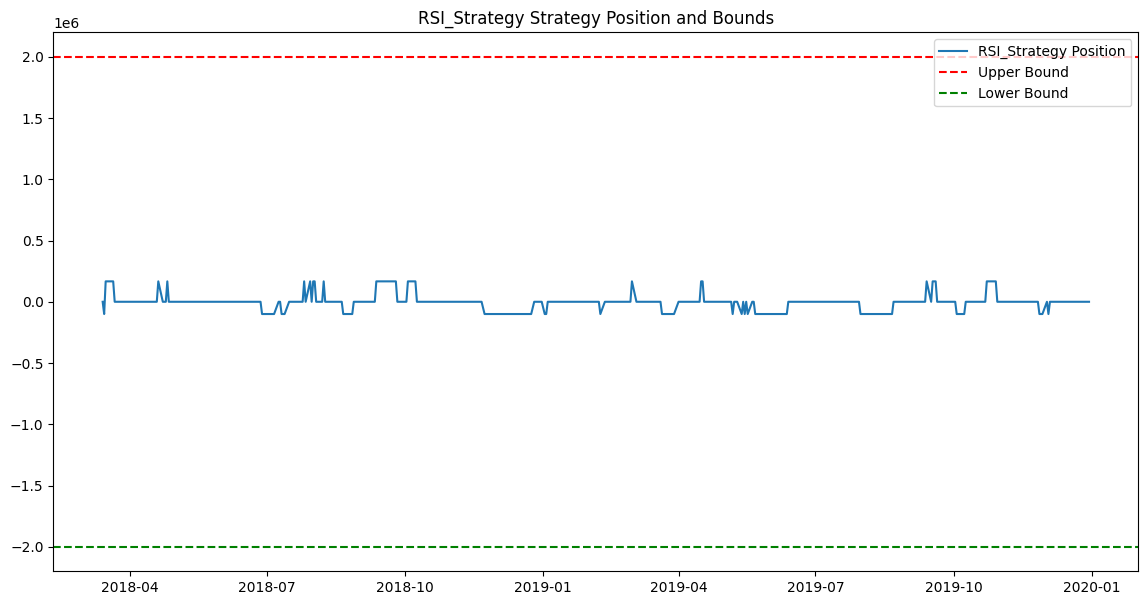

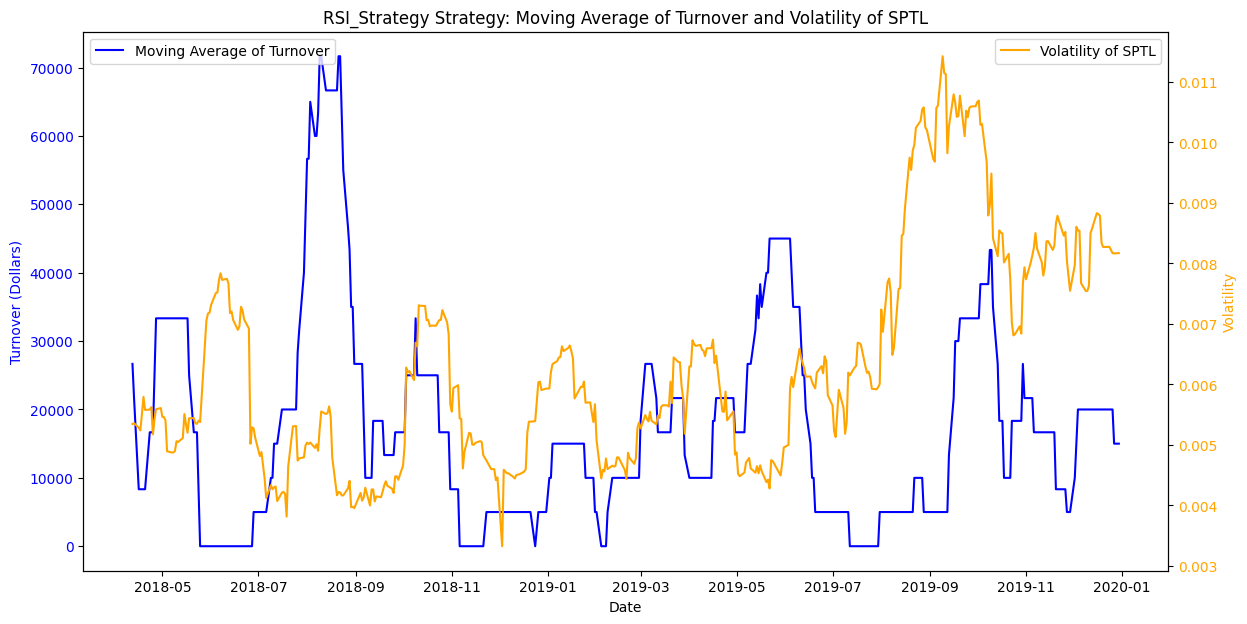

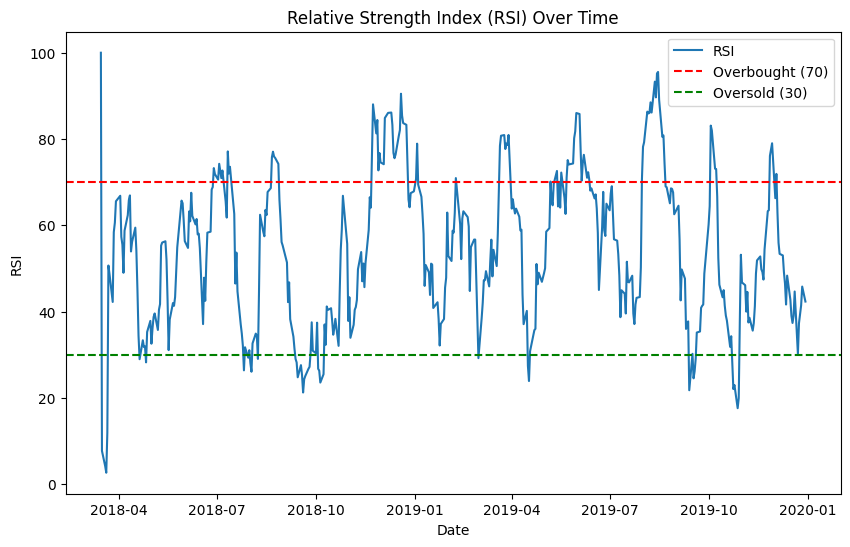

In [20]:
# Define a function to calculate and plot metrics for a given strategy
def calculate_and_plot_strategy_metrics(df, strategy_name, initial_capital, leverage):
    # Calculate turnover in dollar value and in units for the given strategy
    df[strategy_name + '_Turnover_dollars'] = df[strategy_name].diff().abs()
    df[strategy_name + '_Turnover_units'] = (df[strategy_name] / df['Adj Close']).diff().abs()

    # Calculate moving average of the turnover in dollars
    df[strategy_name + '_Turnover_MA'] = df[strategy_name + '_Turnover_dollars'].rolling(window=20).mean()

    # Calculate the volatility of SPTL (standard deviation of returns)
    df['Volatility'] = df['Adj Close'].pct_change().rolling(window=20).std()

    # Plot the strategy position with upper and lower bounds
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[strategy_name], label=strategy_name + ' Position')
    plt.axhline(y=leverage * initial_capital, color='r', linestyle='--', label='Upper Bound')
    plt.axhline(y=-leverage * initial_capital, color='g', linestyle='--', label='Lower Bound')
    plt.title(strategy_name + ' Strategy Position and Bounds')
    plt.legend()
    plt.show()

    # Plot turnover moving average and volatility
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Turnover in Dollars with Moving Average
    ax1.plot(df.index, df[strategy_name + '_Turnover_MA'], label='Moving Average of Turnover', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Turnover (Dollars)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Volatility
    ax2.plot(df.index, df['Volatility'], label='Volatility of SPTL', color='orange')
    ax2.set_ylabel('Volatility', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper right')

    plt.title(strategy_name + ' Strategy: Moving Average of Turnover and Volatility of SPTL')
    plt.show()

# Call the function for each strategy
calculate_and_plot_strategy_metrics(train_df, 'Trend_Following_Strategy', initial_capital, leverage)
calculate_and_plot_strategy_metrics(test_df, 'Trend_Following_Strategy', initial_capital, leverage)

# Calculate the 10-day moving average
df['10_day_MA'] = df['Adj Close'].rolling(window=10).mean()

# Create a plot with a title and labels
plt.figure(figsize=(10, 6))
plt.plot(df['Adj Close'], label='Adjusted Close')
plt.plot(df['10_day_MA'], label='10-Day Moving Average')

plt.title('10-Day Moving Average vs Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

calculate_and_plot_strategy_metrics(train_df, 'Momentum_Strategy', initial_capital, leverage)
calculate_and_plot_strategy_metrics(test_df, 'Momentum_Strategy', initial_capital, leverage)

import matplotlib.pyplot as plt

# Calculate the short-term and long-term moving averages
df['Short_MA'] = df['Adj Close'].rolling(window=short_window).mean()
df['Long_MA'] = df['Adj Close'].rolling(window=long_window).mean()

# Create a plot with a title and labels
plt.figure(figsize=(10, 6))
# plt.plot(df['Adj Close'], label='Adjusted Close')
plt.plot(df['Short_MA'], label=f'{short_window}-Day Moving Average')
plt.plot(df['Long_MA'], label=f'{long_window}-Day Moving Average')

plt.title(f'{short_window}-Day vs {long_window}-Day Moving Average vs Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


calculate_and_plot_strategy_metrics(train_df, 'RSI_Strategy', initial_capital, leverage)
calculate_and_plot_strategy_metrics(test_df, 'RSI_Strategy', initial_capital, leverage)

# Plotting the RSI over time
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['RSI'], label='RSI')
plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI) Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()



### (C)

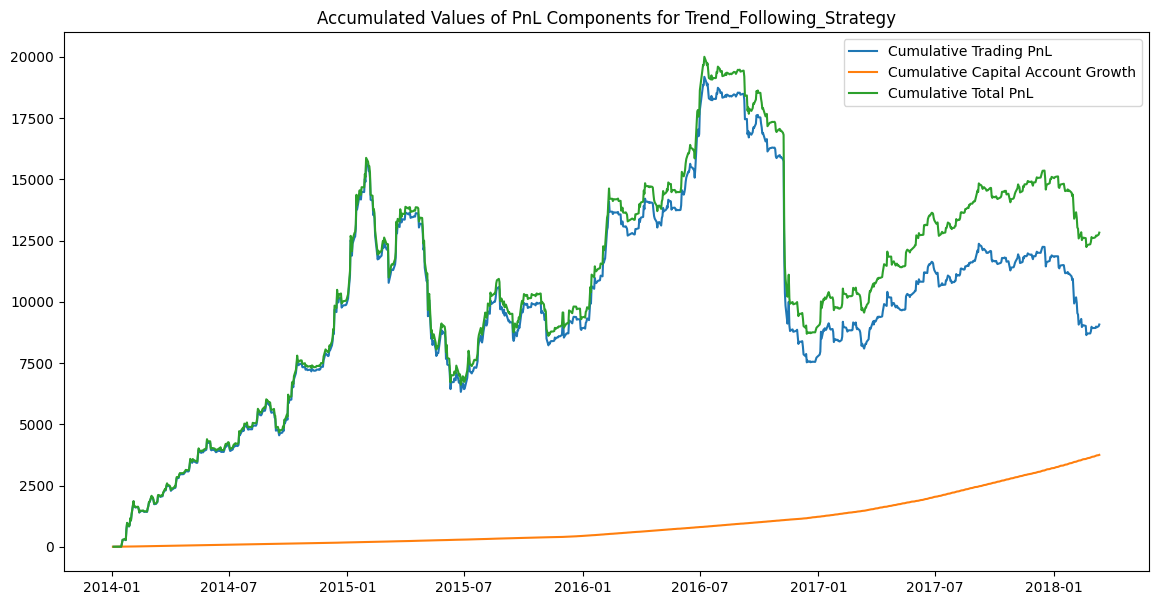

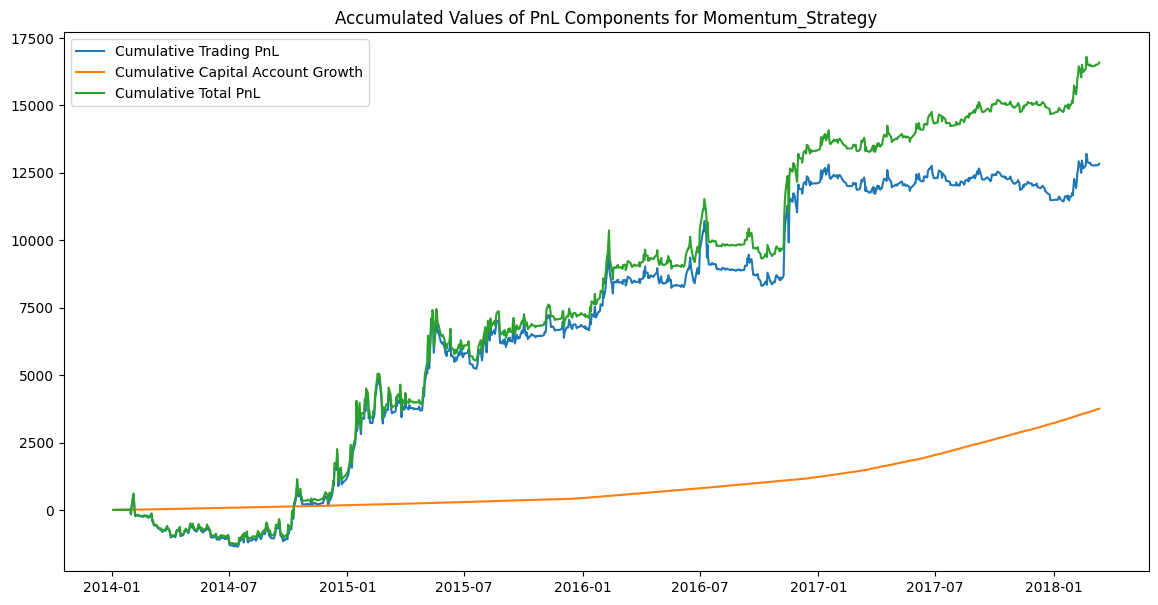

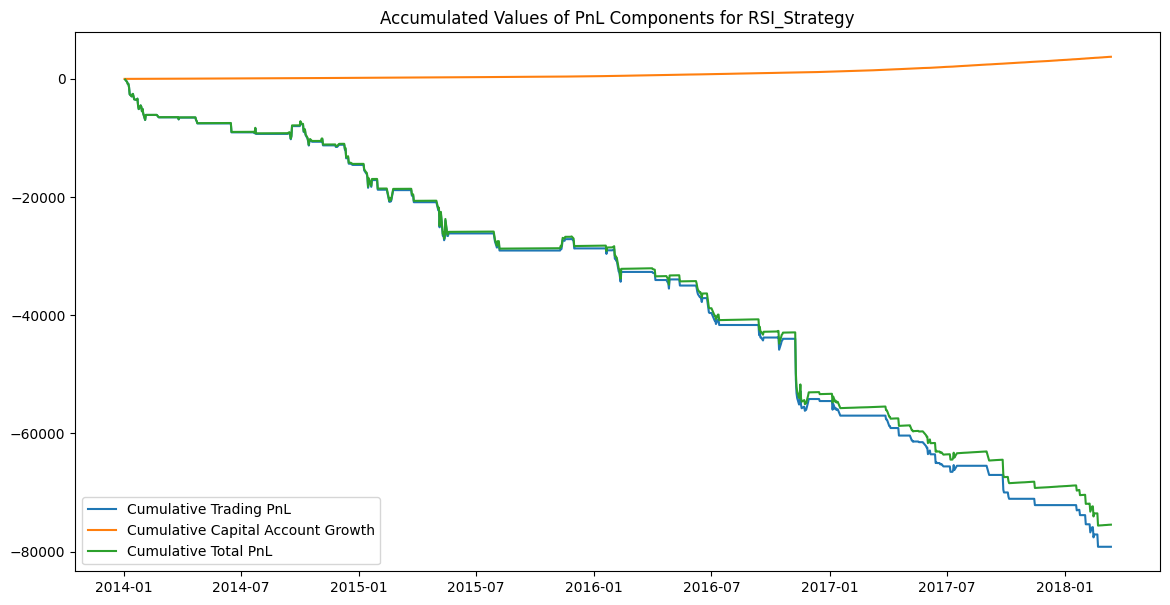

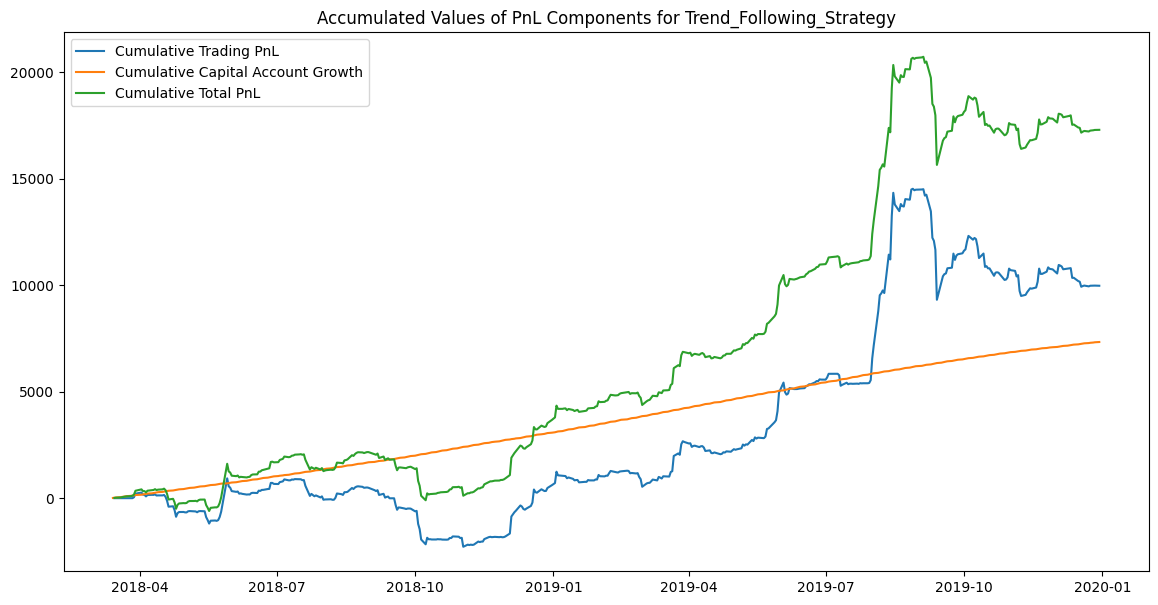

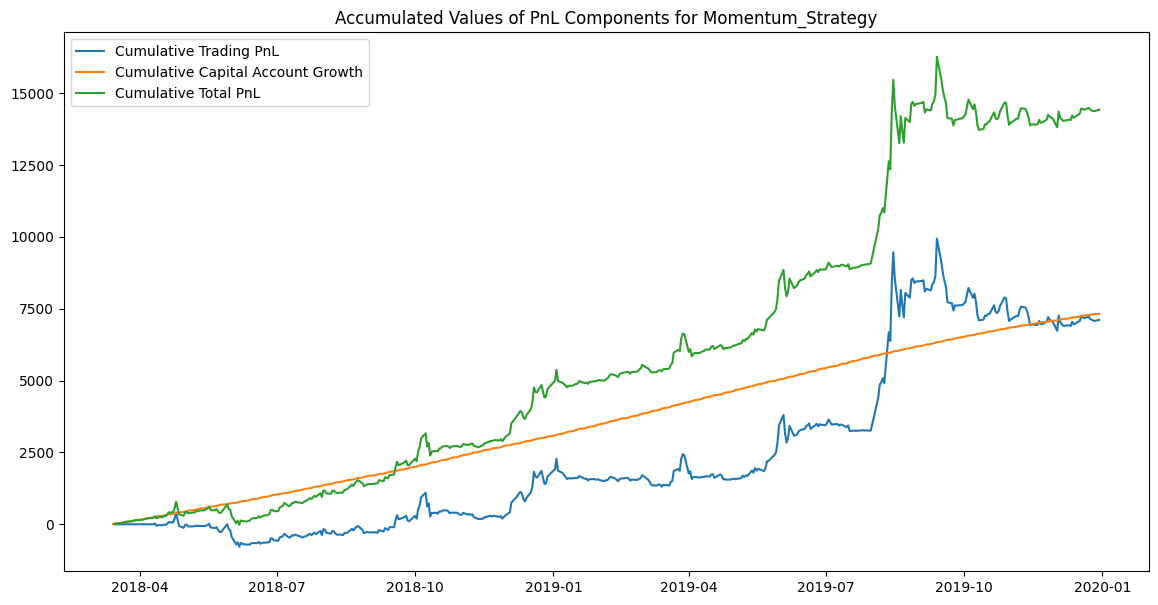

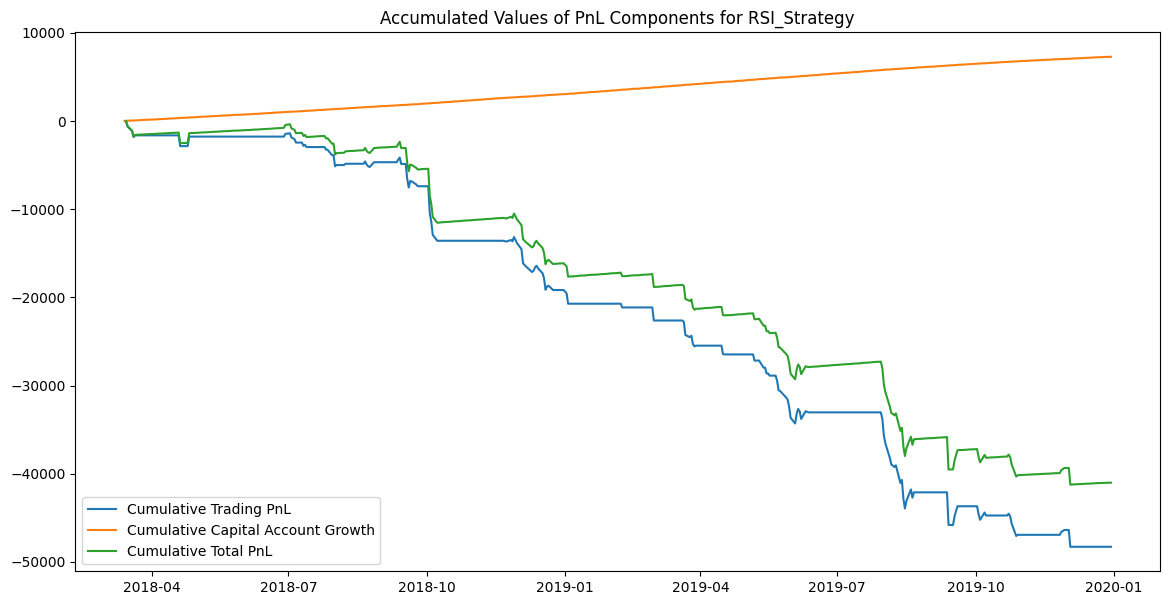

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants
initial_capital = 200000  # initial capital
leverage = 10             # leverage

# Define a function to calculate and plot PnL for a given strategy
def calculate_and_plot_pnl(strategy_name,df):
    # Calculate Mt, which is the total margin used at time t
    df[strategy_name + '_Mt'] = df[strategy_name].abs() / leverage

    # Calculate the trading PnL (Delta Vt)
    df[strategy_name + '_Delta_Vt'] = (df['Adj Close'].diff() - df['Daily Rate']) * (df[strategy_name] / df['Adj Close'])

    # Calculate the change in the growth of the money-market capital account (Delta Vcap)
    df[strategy_name + '_Delta_Vcap'] = (initial_capital - df[strategy_name + '_Mt']) * df['Daily Rate']

    # Calculate the total PnL (Delta Vtotal)
    df[strategy_name + '_Delta_Vtotal'] = df[strategy_name + '_Delta_Vt'] + df[strategy_name + '_Delta_Vcap']

    # Calculate the cumulative PnL
    df[strategy_name + '_Cumulative_Delta_Vt'] = df[strategy_name + '_Delta_Vt'].cumsum()
    df[strategy_name + '_Cumulative_Delta_Vcap'] = df[strategy_name + '_Delta_Vcap'].cumsum()
    df[strategy_name + '_Cumulative_Delta_Vtotal'] = df[strategy_name + '_Delta_Vtotal'].cumsum()

    # Plotting the accumulated values
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[strategy_name + '_Cumulative_Delta_Vt'], label='Cumulative Trading PnL')
    plt.plot(df.index, df[strategy_name + '_Cumulative_Delta_Vcap'], label='Cumulative Capital Account Growth')
    plt.plot(df.index, df[strategy_name + '_Cumulative_Delta_Vtotal'], label='Cumulative Total PnL')
    plt.title(f'Accumulated Values of PnL Components for {strategy_name}')
    plt.legend()
    plt.show()

# Run calculations and plots for each strategy
for strategy in ['Trend_Following_Strategy', 'Momentum_Strategy', 'RSI_Strategy']:
    calculate_and_plot_pnl(strategy,train_df)

for strategy in ['Trend_Following_Strategy', 'Momentum_Strategy', 'RSI_Strategy']:
    calculate_and_plot_pnl(strategy,test_df)



### 3. Performance Indicators [25 Points]

### (a) 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define the functions to calculate each of the performance metrics
def calculate_metrics(df, strategy_name):
    
    # Daily returns and excess returns
    df[strategy_name + '_Daily_Return'] = df[strategy_name + '_PnL'] / initial_capital
    df[strategy_name + '_Excess_Return'] = df[strategy_name + '_Daily_Return'] - df['Daily Rate']

    # Annualize the mean excess return and standard deviation of excess return
    mean_excess_return_annualized = df[strategy_name + '_Excess_Return'].mean() * 252
    std_excess_return_annualized = df[strategy_name + '_Excess_Return'].std() * np.sqrt(252)

    sharpe_ratio = mean_excess_return_annualized / std_excess_return_annualized
    
    # Sortino Ratio
    negative_returns = df[strategy_name + '_Excess_Return'][df[strategy_name + '_Excess_Return'] < 0]
    sortino_ratio = df[strategy_name + '_Excess_Return'].mean() / negative_returns.std() if negative_returns.std() != 0 else np.nan

    # Maximum Drawdown
    cumulative_returns = (1 + df[strategy_name + '_Excess_Return']).cumprod()
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

    # Calmar Ratio
    annualized_return = df[strategy_name + '_Excess_Return'].mean() * 252
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

# Calculate and print the performance metrics for each strategy on both datasets
for strategy in ['Trend_Following', 'Momentum', 'RSI']:
    train_sharpe, train_sortino, train_max_dd, train_calmar = calculate_metrics(train_df, strategy)
    test_sharpe, test_sortino, test_max_dd, test_calmar = calculate_metrics(test_df, strategy)
    
    print(f"{strategy} Strategy Metrics:")
    print(f"Training Set: Sharpe Ratio: {train_sharpe}, Sortino Ratio: {train_sortino}, Maximum Drawdown: {train_max_dd}, Calmar Ratio: {train_calmar}")
    print(f"Test Set: Sharpe Ratio: {test_sharpe}, Sortino Ratio: {test_sortino}, Maximum Drawdown: {test_max_dd}, Calmar Ratio: {test_calmar}\n")


Trend_Following Strategy Metrics:
Training Set: Sharpe Ratio: 0.5039256696741353, Sortino Ratio: 0.033968321827015, Maximum Drawdown: 9.763599102766477, Calmar Ratio: 0.03423874646362472
Test Set: Sharpe Ratio: 1.207486666756926, Sortino Ratio: 0.09776463986429802, Maximum Drawdown: 6.256859640533717, Calmar Ratio: 0.1549305295033222

Momentum Strategy Metrics:
Training Set: Sharpe Ratio: 0.8739765602419169, Sortino Ratio: 0.0768965270556004, Maximum Drawdown: 1.2368634451177707, Calmar Ratio: 0.36777335973938546
Test Set: Sharpe Ratio: 0.9762861775486773, Sortino Ratio: 0.08835862832464883, Maximum Drawdown: 2.0757681440340483, Calmar Ratio: 0.3221469106479741

RSI Strategy Metrics:
Training Set: Sharpe Ratio: -2.49553733844253, Sortino Ratio: -0.17128843136404362, Maximum Drawdown: 0.9870804711011534, Calmar Ratio: -2.840527369914345
Test Set: Sharpe Ratio: -3.692845989729315, Sortino Ratio: -0.24514517461594848, Maximum Drawdown: 0.9955782701953841, Calmar Ratio: -4.400017815283406


### (b)

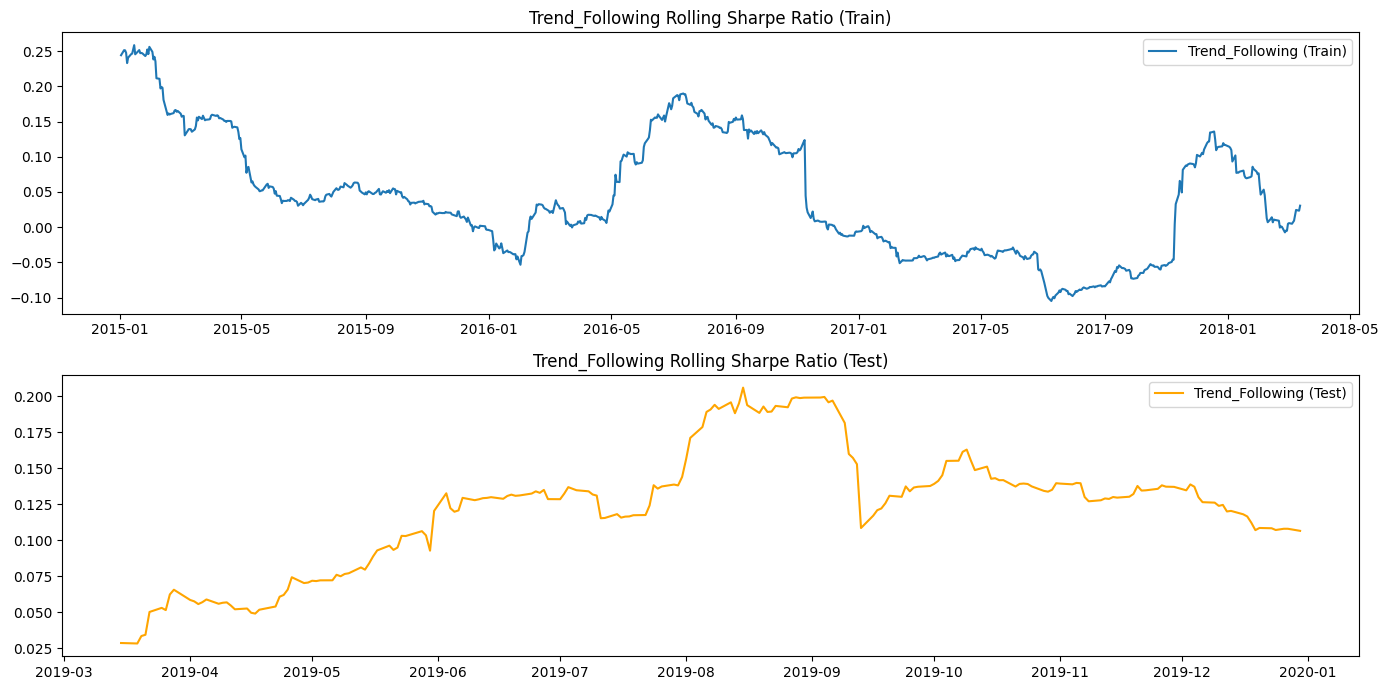

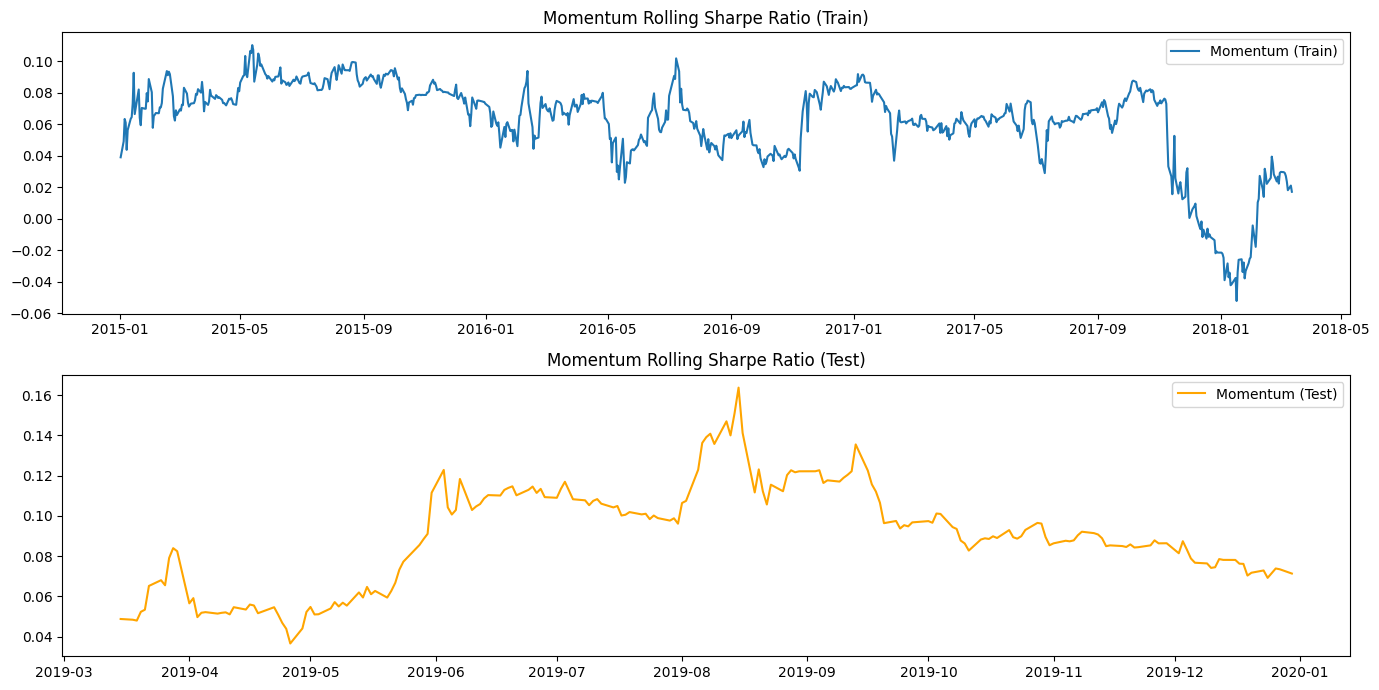

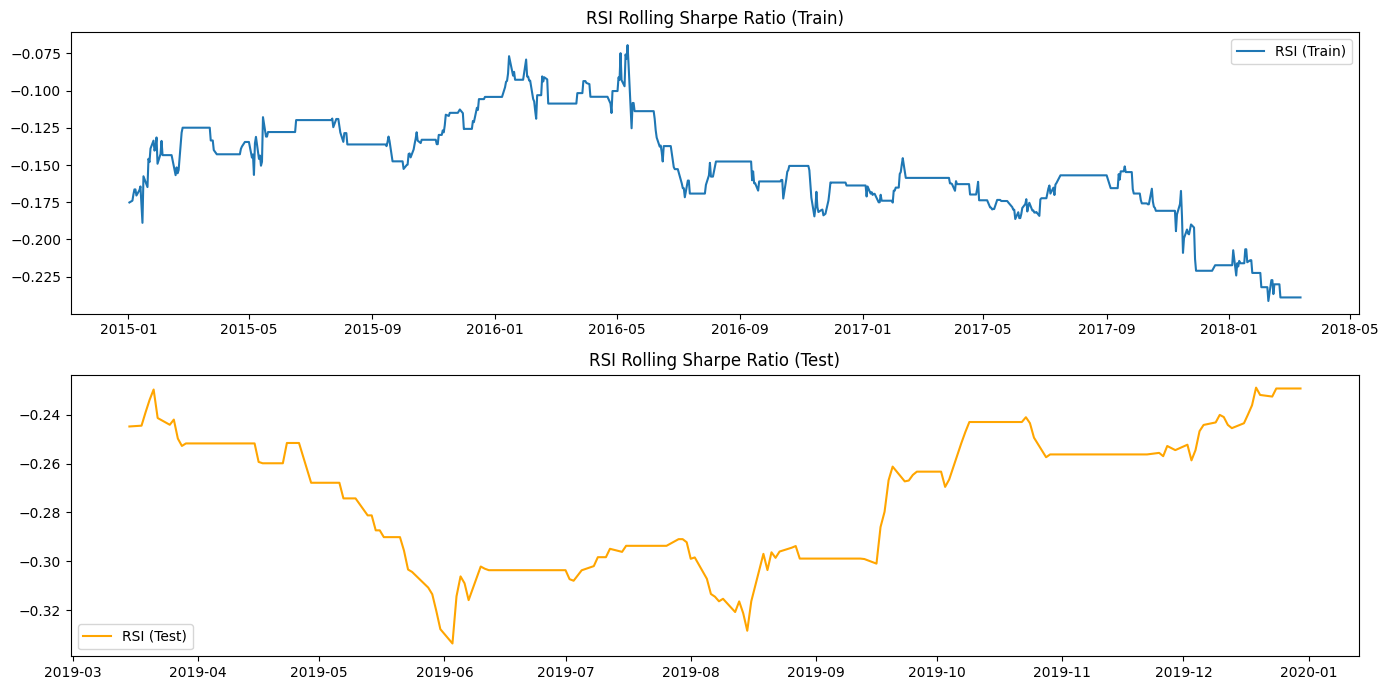

In [23]:
def calculate_rolling_sharpe_ratio(returns, risk_free_rate, rolling_window=252):
    # Excess returns
    excess_returns = returns - risk_free_rate
    # Rolling mean of excess returns
    rolling_mean = excess_returns.rolling(rolling_window).mean()
    # Rolling standard deviation of excess returns
    rolling_std = excess_returns.rolling(rolling_window).std()
    
    # Avoid division by zero
    rolling_std[rolling_std == 0] = np.nan
    
    # Rolling Sharpe Ratio
    rolling_sharpe_ratio = rolling_mean / rolling_std
    return rolling_sharpe_ratio

# Define the rolling window for a year of trading days
rolling_window = 252

# Plot the rolling Sharpe ratio for each strategy
strategies = ['Trend_Following', 'Momentum', 'RSI']
for strategy in strategies:
    # We assume that '_PnL' columns for each strategy have been already calculated
    train_df[strategy + '_Daily_Returns'] = train_df[strategy + '_PnL'] / initial_capital
    test_df[strategy + '_Daily_Returns'] = test_df[strategy + '_PnL'] / initial_capital

    # Daily risk-free rate column 'Daily Rate' should be in decimal format
    train_df['Daily_Risk_Free_Rate'] = train_df['Daily Rate'] / 100
    test_df['Daily_Risk_Free_Rate'] = test_df['Daily Rate'] / 100

    # Calculate rolling Sharpe ratio
    train_df[strategy + '_Rolling_Sharpe'] = calculate_rolling_sharpe_ratio(
        train_df[strategy + '_Daily_Returns'], train_df['Daily_Risk_Free_Rate'], rolling_window)
    test_df[strategy + '_Rolling_Sharpe'] = calculate_rolling_sharpe_ratio(
        test_df[strategy + '_Daily_Returns'], test_df['Daily_Risk_Free_Rate'], rolling_window)

    # Plot the rolling Sharpe ratio
    plt.figure(figsize=(14, 7))
    
    # Training set rolling Sharpe ratio
    plt.subplot(2, 1, 1)
    plt.plot(train_df.index, train_df[strategy + '_Rolling_Sharpe'], label=f'{strategy} (Train)')
    plt.title(f'{strategy} Rolling Sharpe Ratio (Train)')
    plt.legend()

    # Test set rolling Sharpe ratio
    plt.subplot(2, 1, 2)
    plt.plot(test_df.index, test_df[strategy + '_Rolling_Sharpe'], label=f'{strategy} (Test)', color='orange')
    plt.title(f'{strategy} Rolling Sharpe Ratio (Test)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### (c)

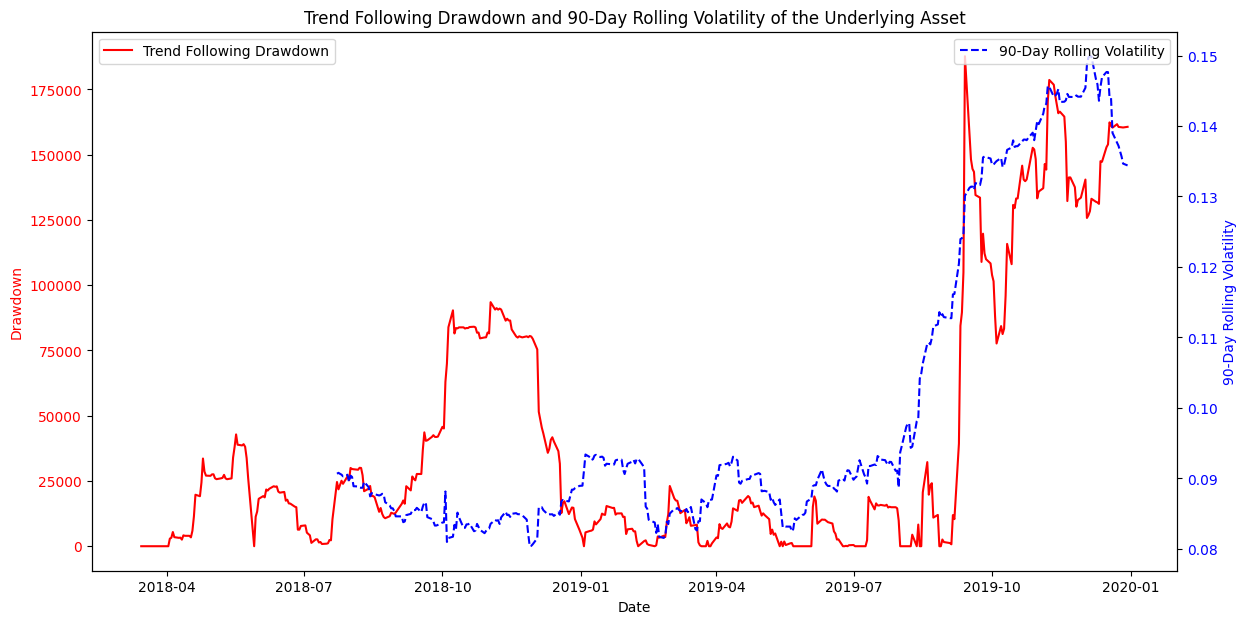

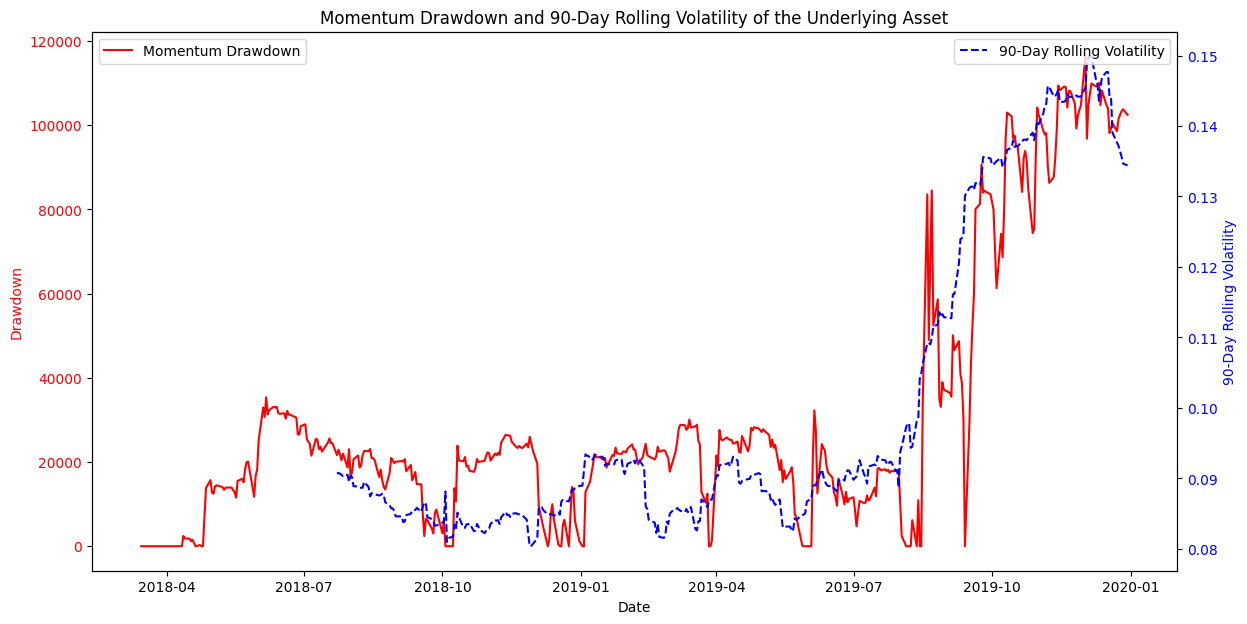

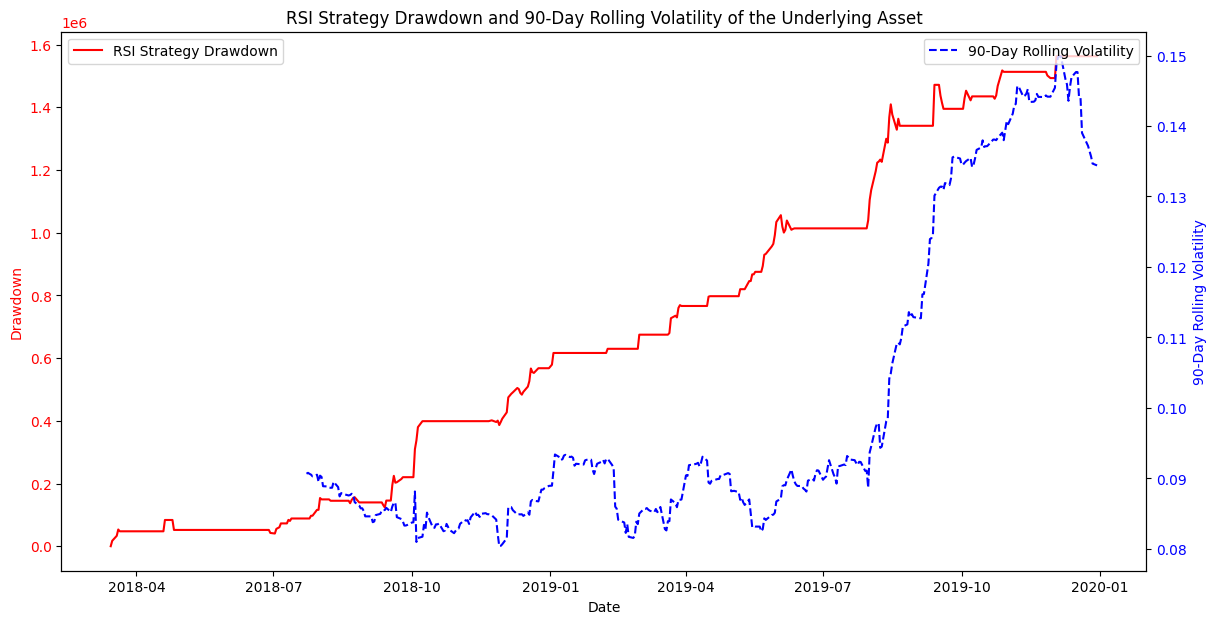

In [24]:
# Define a function to calculate drawdown and rolling volatility
def calculate_drawdown_rolling_volatility(df, pnl_column):
    # Calculate the cumulative PnL for the strategy
    df['Cumulative_' + pnl_column] = df[pnl_column].cumsum()

    # Calculate the running maximum
    df['Running_Max_' + pnl_column] = df['Cumulative_' + pnl_column].cummax()

    # Calculate drawdown
    df['Drawdown_' + pnl_column] = df['Running_Max_' + pnl_column] - df['Cumulative_' + pnl_column]

    # Calculate the rolling 90-day volatility of the underlying asset
    volatility_window = 90  # Adjust the window size if needed
    df['Rolling_Volatility'] = df['Adj Close'].pct_change().rolling(volatility_window).std() * np.sqrt(252)

# Plot the drawdown and rolling volatility for each strategy
def plot_drawdown_rolling_volatility(df, pnl_column, strategy_name):
    calculate_drawdown_rolling_volatility(df, pnl_column)
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Drawdown plot
    ax1.plot(df.index, df['Drawdown_' + pnl_column], label=strategy_name + ' Drawdown', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Drawdown', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Rolling volatility plot
    ax2.plot(df.index, df['Rolling_Volatility'], label='90-Day Rolling Volatility', color='blue', linestyle='--')
    ax2.set_ylabel('90-Day Rolling Volatility', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

    plt.title(f'{strategy_name} Drawdown and 90-Day Rolling Volatility of the Underlying Asset')
    plt.show()

# Apply the function for each strategy's PnL'Trend_Following', 'Mean_Reversion', 'AR'
plot_drawdown_rolling_volatility(test_df, 'Trend_Following_PnL', 'Trend Following')
plot_drawdown_rolling_volatility(test_df, 'Momentum_PnL', 'Momentum')
plot_drawdown_rolling_volatility(test_df, 'RSI_PnL', 'RSI Strategy')